<a href="https://colab.research.google.com/github/alexc6h6/Natural-Language-Process_RNN/blob/master/English_Franch_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, GRU, TimeDistributed, Dense, BatchNormalization, Activation, Bidirectional, Dropout, Concatenate, LayerNormalization, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import re
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam

print(tf.__version__)


2.2.0


In [2]:
#!pip install --upgrade tensorflow

In [3]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [4]:
data = pd.read_table('/content/drive/My Drive/fra-eng-2/fra.txt', header = None)

In [5]:
print(data.head())

      0         1                                                  2
0   Go.      Va !  CC-BY 2.0 (France) Attribution: tatoeba.org #2...
1   Hi.   Salut !  CC-BY 2.0 (France) Attribution: tatoeba.org #5...
2   Hi.    Salut.  CC-BY 2.0 (France) Attribution: tatoeba.org #5...
3  Run!   Cours !  CC-BY 2.0 (France) Attribution: tatoeba.org #9...
4  Run!  Courez !  CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [6]:
eng = []
fra = []

for line in data.values:
  eng.append(line[0])
  fra.append(line[1])

eng = np.asarray(eng)
fra = np.asarray(fra)

print(fra.shape)
print(eng.shape)


(174481,)
(174481,)


In [7]:
def clean_eng_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = re.sub(r"\u202f", "", text)
    
    return text

In [8]:
def clean_fra_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = re.sub(r"\u202f", "", text)
    text = re.sub(r"\xa0", "", text)
    
    return text

In [9]:
fra_cleaned = [clean_fra_text(text) for text in fra]
eng_cleaned = [clean_eng_text(text) for text in eng]


In [10]:
fra_sample = fra_cleaned[:50000]
eng_sample = eng_cleaned[:50000]

print(len(fra_sample))
print(len(eng_sample))


50000
50000


In [11]:
print(fra_sample[:10])
print(eng_sample[:10])


['va ', 'salut ', 'salut', 'cours', 'courez', 'qui ', 'ça alors', 'au feu ', "à l'aide", 'saute']
['go', 'hi', 'hi', 'run', 'run', 'who', 'wow', 'fire', 'help', 'jump']


In [12]:
from sklearn.model_selection import train_test_split

fra_train, fra_val, eng_train, eng_val = train_test_split(fra_sample, eng_sample, test_size = 0.3)

In [13]:
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(fra_train)
fra_word_index = fra_tokenizer.word_index #fra index
fra_num_vocab = len(fra_word_index) +1  #fra number of vocab

fra_train_sequences = fra_tokenizer.texts_to_sequences(fra_train)
fra_val_sequences = fra_tokenizer.texts_to_sequences(fra_val)

fra_max_len = np.max([len(x) for x in fra_train_sequences])
  
fra_train_pad = pad_sequences(fra_train_sequences, maxlen = fra_max_len, padding = 'pre') #eng train sequence
fra_val_pad = pad_sequences(fra_val_sequences, maxlen = fra_max_len, padding = 'pre') #eng val sequence


In [14]:
print(fra_word_index)
print(fra_num_vocab)
print(fra_max_len)
print(fra_train_pad.shape)
print(fra_train_pad[:2])

{'je': 1, 'pas': 2, 'de': 3, 'vous': 4, 'ne': 5, 'il': 6, 'le': 7, 'est': 8, 'tom': 9, 'nous': 10, 'suis': 11, 'la': 12, 'un': 13, 'à': 14, 'que': 15, "c'est": 16, "j'ai": 17, 'tu': 18, 'a': 19, 'en': 20, 'une': 21, 'me': 22, 'ce': 23, 'ça': 24, 'les': 25, 'elle': 26, 'êtes': 27, 'tout': 28, 'fait': 29, 'qui': 30, 'mon': 31, 'sont': 32, 'estce': 33, 'te': 34, 'faire': 35, 'sommes': 36, 'très': 37, 'des': 38, 'es': 39, "n'est": 40, 'ils': 41, 'pour': 42, 'veux': 43, 'cela': 44, 'votre': 45, 'moi': 46, 'y': 47, 'ici': 48, 'du': 49, 'peux': 50, 'bien': 51, 'comment': 52, 'elles': 53, 'été': 54, 'se': 55, 'pourquoi': 56, 'êtesvous': 57, 'personne': 58, 'besoin': 59, 'ma': 60, 'ton': 61, 'où': 62, 'avec': 63, 'dans': 64, 'aller': 65, 'cette': 66, 'avons': 67, 'était': 68, 'trop': 69, 'toi': 70, 'si': 71, 'plus': 72, 'maintenant': 73, 'au': 74, "l'air": 75, 'tous': 76, 'vraiment': 77, 'faut': 78, 'être': 79, 'sais': 80, "n'ai": 81, 'train': 82, 'monde': 83, 'lui': 84, "j'aime": 85, 'as': 86,

In [15]:
bos = '<BOS> ' #beginning of sentence
eos = ' <EOS>' #end of sentence

eng_train_input = [bos + text for text in eng_train]  #decoder input
eng_train_output = [text + eos for text in eng_train]  #decoder output

eng_val_input = [bos + text for text in eng_val]  
eng_val_output = [text + eos for text in eng_val]  

print(eng_train_input[:2])
print(eng_train_output[:2])

['<BOS> we are certain', '<BOS> you are my daughter']
['we are certain <EOS>', 'you are my daughter <EOS>']


In [16]:
eng_tokenizer = Tokenizer(filters = '')
eng_tokenizer.fit_on_texts(eng_train_input + eng_train_output)

eng_word_index = eng_tokenizer.word_index #eng index
eng_num_vocab = len(eng_word_index) +1 #eng number of vocab

eng_train_input_sequences = eng_tokenizer.texts_to_sequences(eng_train_input)
eng_train_output_sequences = eng_tokenizer.texts_to_sequences(eng_train_output)

eng_val_input_sequences = eng_tokenizer.texts_to_sequences(eng_val_input)
eng_val_output_sequences = eng_tokenizer.texts_to_sequences(eng_val_output)

eng_max_len = np.max([len(x) for x in eng_train_input_sequences])
  
eng_train_input_pad = pad_sequences(eng_train_input_sequences, maxlen = eng_max_len, padding = 'post') 
eng_train_output_pad = pad_sequences(eng_train_output_sequences, maxlen = eng_max_len, padding = 'post') 

eng_val_input_pad = pad_sequences(eng_val_input_sequences, maxlen = eng_max_len, padding = 'post') 
eng_val_output_pad = pad_sequences(eng_val_output_sequences, maxlen = eng_max_len, padding = 'post') 



In [17]:
print(eng_word_index)
print(eng_num_vocab, eng_max_len)
print(eng_train_input_pad.shape, eng_train_output_pad.shape)
print(eng_train_input_pad[:2])
print(eng_train_output_pad[:2])

{'<bos>': 1, '<eos>': 2, 'i': 3, 'you': 4, 'is': 5, 'are': 6, 'a': 7, 'it': 8, 'not': 9, 'do': 10, 'the': 11, 'to': 12, 'that': 13, 'he': 14, 'am': 15, 'tom': 16, 'we': 17, 'have': 18, 'this': 19, 'me': 20, 'was': 21, 'will': 22, 'my': 23, 'did': 24, 'your': 25, 'they': 26, 'she': 27, 'be': 28, 'go': 29, 'can': 30, 'all': 31, 'like': 32, 'what': 33, 'no': 34, 'in': 35, 'of': 36, 'very': 37, 'how': 38, 'want': 39, 'here': 40, 'on': 41, 'know': 42, 'cannot': 43, 'for': 44, 'him': 45, 'need': 46, 'one': 47, 'get': 48, 'up': 49, 'at': 50, 'so': 51, 'now': 52, 'why': 53, 'good': 54, 'just': 55, 'out': 56, 'too': 57, 'has': 58, 'please': 59, 'come': 60, 'were': 61, 'there': 62, 'got': 63, 'who': 64, 'where': 65, 'love': 66, 'us': 67, 'his': 68, 'see': 69, 'look': 70, 'with': 71, 'think': 72, 'her': 73, 'help': 74, "let's": 75, 'had': 76, 'really': 77, 'take': 78, 'would': 79, 'right': 80, 'home': 81, 'an': 82, 'let': 83, 'must': 84, 'back': 85, 'work': 86, 'stop': 87, 'happy': 88, 'give': 89

In [18]:
fra_word2index = fra_word_index
eng_word2index = eng_word_index
fra_index2word = {i:v for v, i in fra_word2index.items()}
eng_index2word = {i:v for v, i in eng_word2index.items()}

print(eng_word2index['<bos>'], eng_word2index['<eos>'], eng_index2word[1], eng_index2word[2])

1 2 <bos> <eos>


In [19]:
print(fra_train[:2])
print(fra_train_pad[:2])
print(eng_train[:2])
print(eng_train_input_pad[:2])
print(eng_train_output_pad[:2])

['nous sommes certains', 'vous êtes ma fille']
[[   0    0    0    0    0    0    0    0    0    0    0   10   36 3090]
 [   0    0    0    0    0    0    0    0    0    0    4   27   60  259]]
['we are certain', 'you are my daughter']
[[   1   17    6 1058    0    0    0    0]
 [   1    4    6   23  700    0    0    0]]
[[  17    6 1058    2    0    0    0    0]
 [   4    6   23  700    2    0    0    0]]


In [20]:
print(fra_train_pad.shape)
print(eng_train_output_pad.shape)

(35000, 14)
(35000, 8)


In [21]:

eng_train_output_onehot = np.zeros((len(eng_train_output_pad), eng_max_len, eng_num_vocab), dtype="float32")

for i, seqs in enumerate(eng_train_output_pad):
  for j, seq in enumerate(seqs):
    eng_train_output_onehot[i, j, seq] = 1
print(eng_train_output_onehot.shape)
print(eng_train_output_onehot[:2])


(35000, 8, 5340)
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]]]


In [22]:
embedding_dictionary = dict()

glove_file = open(r'/content/drive/My Drive/glove.6B.100d.txt', encoding = 'utf-8')

for line in glove_file:
  record = line.split()
  word = record[0]
  word_vector = np.asarray(record[1:], dtype = 'float32')
  embedding_dictionary[word] = word_vector

glove_file.close()

In [23]:
embedding_matrix = np.zeros((eng_num_vocab, 100))

for word, index in eng_word2index.items():
  embedding_vector = embedding_dictionary.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector


In [24]:
embedding_matrix.shape

(5340, 100)

In [25]:
units = 128
#encoder model
encoder_inputs = Input(shape = (fra_max_len, ), dtype = 'int32', name = 'encoder_input')
encoder_embedding = Embedding(input_dim = fra_num_vocab, output_dim = 128, input_length = fra_max_len, name = 'encoder_embedding')
encoder_lstm_1 = Bidirectional(LSTM(units, return_sequences = True, name = 'encoder_lstm_1'), name = 'encoder_bi_1')
encoder_ln = LayerNormalization(name = 'encoder_ln')
encoder_lstm_2 = Bidirectional(LSTM(units, return_state = True, name = 'encoder_lstm_2'), name = 'encoder_bi_2')

encoder_x = encoder_embedding(encoder_inputs)
encoder_x = encoder_lstm_1(encoder_x)
encoder_x = encoder_ln(encoder_x)
encoder_output, state_h_f, state_c_f, state_h_b, state_c_b = encoder_lstm_2(encoder_x)

state_h = Concatenate()([state_h_f, state_h_b])
state_c = Concatenate()([state_c_f, state_c_b])
#encoder_states = [state_h, state_c]

#decoder model
decoder_inputs = Input(shape = (eng_max_len, ), dtype = 'int32', name = 'decoder_input')
decoder_embedding = Embedding(input_dim = eng_num_vocab, output_dim = 100, weights = [embedding_matrix],
                              input_length = eng_max_len, name = 'decoder_embedding')
decoder_lstm_1 = LSTM(units*2, return_sequences = True, return_state = True, name = 'decoder_lstm_1')

decoder_x = decoder_embedding(decoder_inputs)
decoder_x, _, _ = decoder_lstm_1(decoder_x, initial_state = [state_h, state_c])

dense_1 = Dense(units*4, kernel_regularizer = tf.keras.regularizers.l2(0.5), name = 'dense_1')
bn_1 = BatchNormalization()
ac_1 = Activation('relu')
dp_1 = Dropout(0.5)
dense_x = dp_1(ac_1(bn_1(dense_1(decoder_x))))

decoder_dense = Dense(eng_num_vocab, activation = 'softmax', name = 'dense')
outputs = decoder_dense(dense_x)
model = Model([encoder_inputs, decoder_inputs], outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 14)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 14, 128)      1383168     encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_bi_1 (Bidirectional)    (None, 14, 256)      263168      encoder_embedding[0][0]          
__________________________________________________________________________________________________
encoder_ln (LayerNormalization) (None, 14, 256)      512         encoder_bi_1[0][0]               
______________________________________________________________________________________________

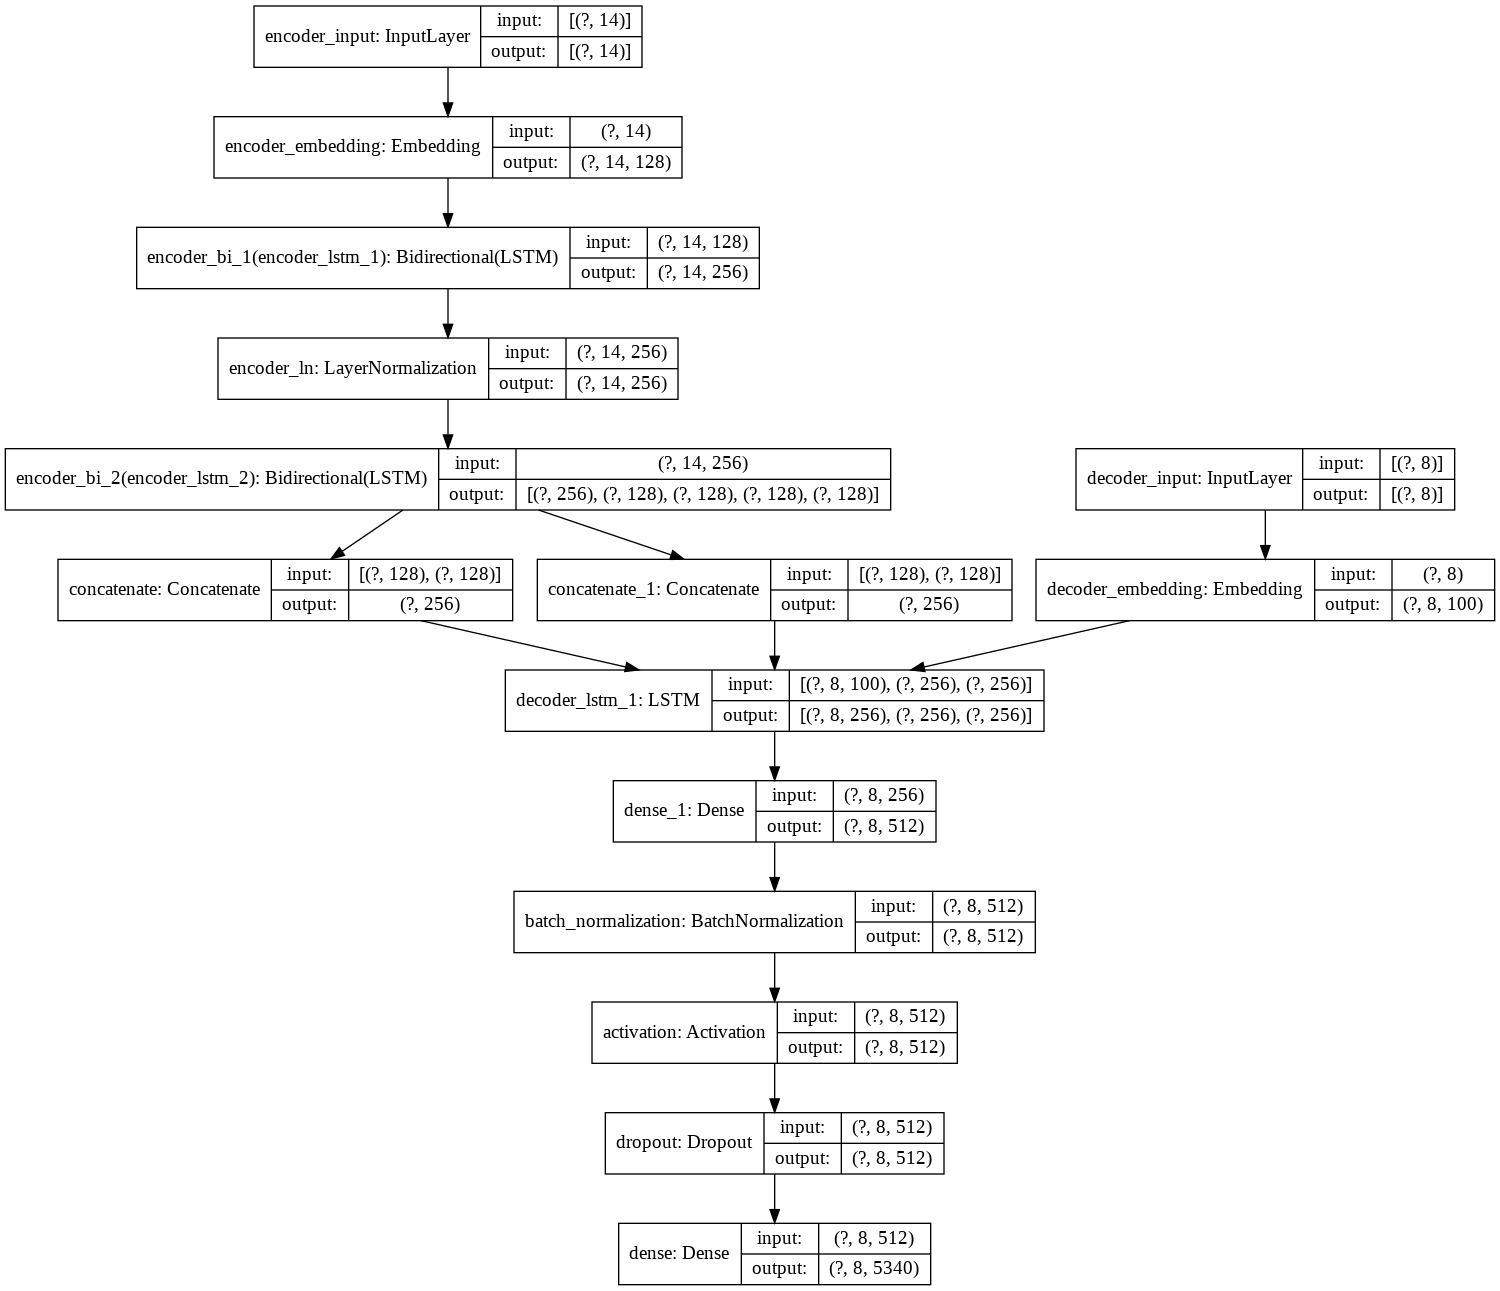

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True )

In [27]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 8, verbose = 1, min_lr = 0, factor = 0.33)

In [28]:
adam = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [29]:
history = model.fit([fra_train_pad, eng_train_input_pad], eng_train_output_onehot, 
                    batch_size = 128, 
                    epochs = 50, 
                    verbose = 1,
                    validation_split = 0.05, 
                    callbacks = [reduce_lr])

Epoch 1/50
260/260 [==============================] - 15s 57ms/step - loss: 37.0131 - accuracy: 0.5656 - val_loss: 6.5956 - val_accuracy: 0.6151 - lr: 5.0000e-04
Epoch 2/50
260/260 [==============================] - 13s 52ms/step - loss: 2.2494 - accuracy: 0.6582 - val_loss: 2.7966 - val_accuracy: 0.6829 - lr: 5.0000e-04
Epoch 3/50
260/260 [==============================] - 13s 52ms/step - loss: 1.8862 - accuracy: 0.6979 - val_loss: 1.8696 - val_accuracy: 0.7073 - lr: 5.0000e-04
Epoch 4/50
260/260 [==============================] - 13s 52ms/step - loss: 1.6793 - accuracy: 0.7229 - val_loss: 1.7404 - val_accuracy: 0.7262 - lr: 5.0000e-04
Epoch 5/50
260/260 [==============================] - 13s 51ms/step - loss: 1.5200 - accuracy: 0.7444 - val_loss: 1.6352 - val_accuracy: 0.7432 - lr: 5.0000e-04
Epoch 6/50
260/260 [==============================] - 13s 51ms/step - loss: 1.3817 - accuracy: 0.7638 - val_loss: 1.5787 - val_accuracy: 0.7500 - lr: 5.0000e-04
Epoch 7/50
260/260 [=============

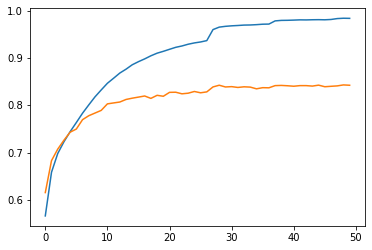

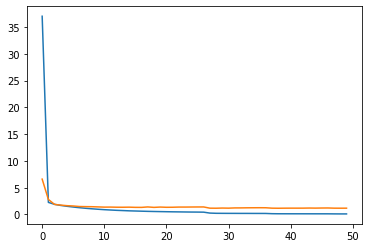

In [30]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

In [31]:
model.save('/content/drive/My Drive/model.h5')


In [32]:
model.save_weights('/content/drive/My Drive/model_weights.h5')

In [33]:
encoder_model = Model(encoder_inputs, [state_h, state_c])

encoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 14)]         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, 14, 128)      1383168     encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_bi_1 (Bidirectional)    (None, 14, 256)      263168      encoder_embedding[0][0]          
__________________________________________________________________________________________________
encoder_ln (LayerNormalization) (None, 14, 256)      512         encoder_bi_1[0][0]               
____________________________________________________________________________________________

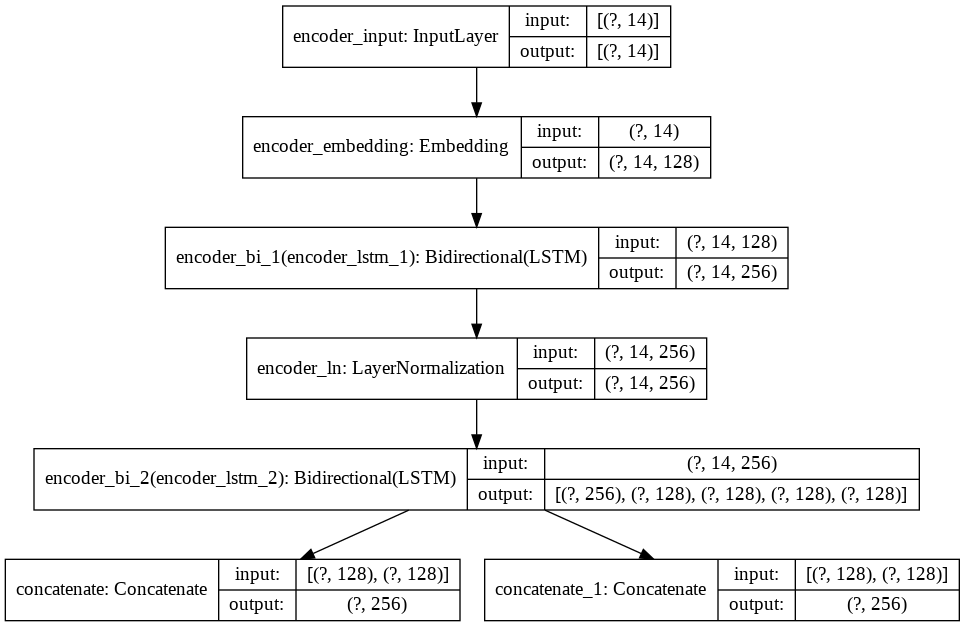

In [34]:
from tensorflow.keras.utils import plot_model
plot_model(encoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True )

In [35]:
#initial state from encoder
decoder_state_h = Input(shape = (units*2, ))
decoder_state_c = Input(shape = (units*2, ))
decoder_state_inputs = [decoder_state_h, decoder_state_c]

#decoder layer
decoder_input_single = Input(shape = (1, ), dtype = 'int32')
decoder_x_single = decoder_embedding(decoder_input_single)
decoder_x_single, decoder_h, decoder_c = decoder_lstm_1(decoder_x_single, initial_state = decoder_state_inputs)

                               
#fully connected layer
decoder_x_single = dp_1(ac_1(bn_1(dense_1(decoder_x_single))))

outputs_single = decoder_dense(decoder_x_single)

decoder_model = Model([decoder_input_single] + decoder_state_inputs,
                      [outputs_single] + [decoder_h, decoder_c])

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
decoder_embedding (Embedding)   multiple             534000      input_3[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 256)]        0                                            
____________________________________________________________________________________________

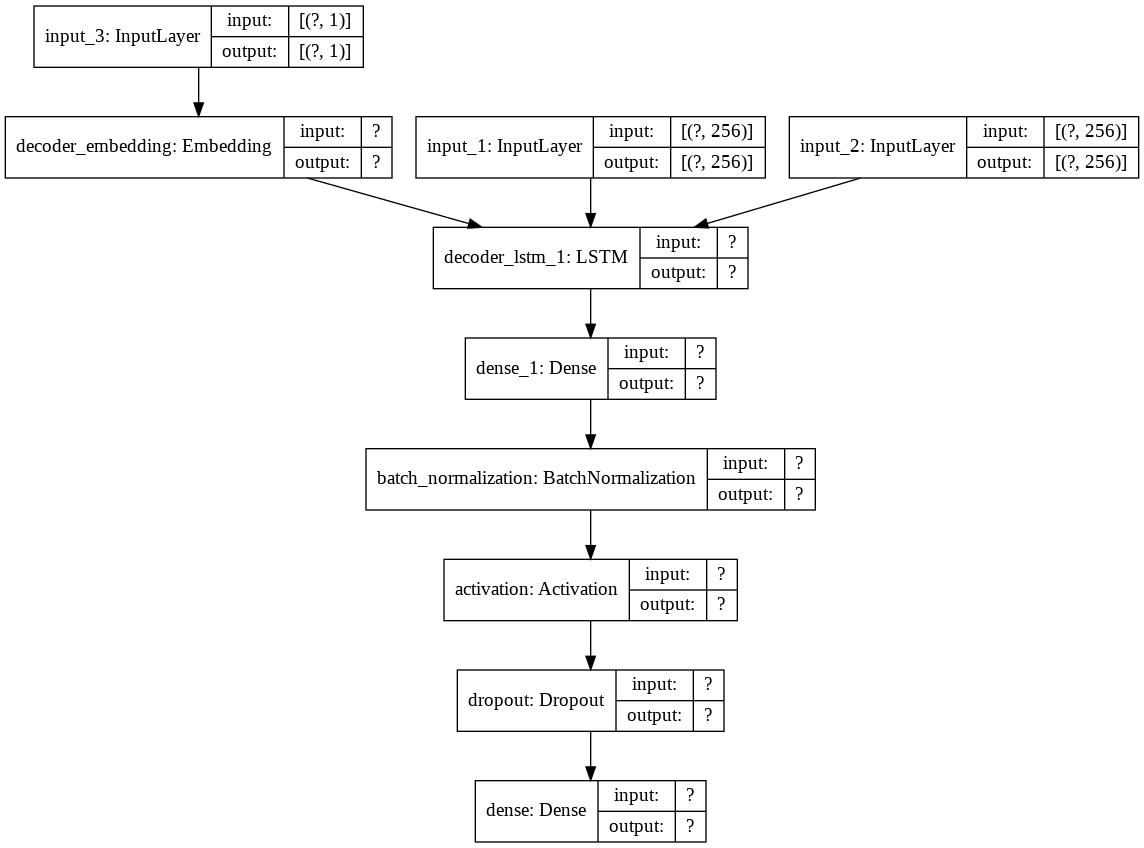

In [36]:
from tensorflow.keras.utils import plot_model
plot_model(decoder_model, to_file='model_plot_dec.png', show_shapes=True, show_layer_names=True)

In [37]:
def translate_sequences(input_sequences):
  state_value = encoder_model.predict(input_sequences)
  #generate sequence of length 1 with only beginning of sentence
  target_sequence = np.zeros((1, 1))
  target_sequence[0, 0] = eng_word2index['<bos>']

  decoded_sentence = []

  for i in range(eng_max_len):
    output_token, h, c = decoder_model.predict([target_sequence] + state_value)
    sample_token_index = np.argmax(output_token[0, 0, :])
    if sample_token_index == eng_word2index['<eos>']:
      break

    sample_word = ''

    if sample_token_index > 0:
      sample_word = eng_index2word[sample_token_index]
      decoded_sentence.append(sample_word)

    target_sequence[0, 0] = sample_token_index
    state_value = [h, c]

  return decoded_sentence

In [56]:
for t in range(5):
  i = int(np.random.choice(len(fra_val)))

  print('Validation Input Franch: '+ str(fra_val[i:i+1]))
  print('Validation Output English: ' + str(eng_val[i:i+1]))

  #print(fra_val_pad[i:i+1])
  #print(eng_train_input_pad[i:i+1])

  input_pad_sequence = fra_val_pad[i:i+1]

  decoded_sentence = translate_sequences(input_pad_sequence)

  print('Output English: ' + str(decoded_sentence))

  print('-------------------------------------------------------------------------------')


Validation Input Franch: ["astu besoin d'aide "]
Validation Output English: ['do you need help']
Output English: ['do', 'you', 'need', 'help']
-------------------------------------------------------------------------------
Validation Input Franch: ['je suis coincé à boston']
Validation Output English: ['i am stuck in boston']
Output English: ['i', 'am', 'stuck', 'in', 'boston']
-------------------------------------------------------------------------------
Validation Input Franch: ["j'ai une idée"]
Validation Output English: ['i have an idea']
Output English: ['i', 'have', 'a', 'idea']
-------------------------------------------------------------------------------
Validation Input Franch: ['tom va nous manquer']
Validation Output English: ['we will miss tom']
Output English: ['tom', 'will', 'be', 'missed']
-------------------------------------------------------------------------------
Validation Input Franch: ["j'ai acheté un parapluie"]
Validation Output English: ['i bought an umbrell